Welcome to this notebook to write a simple CNN to classify some standard image datasets. We will make use of `tensorflow` and its high-level API `keras`. You could also do this in other frameworks such as a `PyTorch` if you wanted to.

Aims:


1.   Write your first CNN using `keras`
2.   Consider how to make the model more complex and adapt it to different tasks
3.   See how different layers change the number of parameters in the model


At various points in the code you will come across the word `None`. Whilst this is actually a keyword in python, all instances in this notebook should be replaced by the actual code required. Clues will be given with the names of functions that you will need to use.



In [1]:
import tensorflow
from tensorflow import keras
from keras.datasets import mnist, cifar10, cifar100
import numpy as np
import matplotlib.pyplot as plot

print('Tensorflow version:',tensorflow.__version__)


Tensorflow version: 2.15.0


---

You can use the function below to load some of the simple datasets available directly from `keras`. There are three options for the `dataset_name` argument:
1. `mnist`: the dataset used for the original CNN paper, consisting of handwritten digits from 0 - 9. These images are (28,28,1) in shape
2. `cifar10`: these are small colour images with shape (32,32,3) from ten different classes (plane, car, bird, cat, deer, dog, frog, horse, ship, truck)
3. `cifar100`: as above but with 100 classes! This will likely not be feasible to use with just a CPU as it would take a fairly complex network with many parameters. I have included it in case you want to play with this on a GPU one day

In [2]:
def load_dataset(dataset_name='mnist'):
  # MNIST, CIFAR10 and CIFAR100 are standard datasets we can load straight
  # from keras. The data are split between train and test sets automatically
  # - x_train is a numpy array that stores the training images
  # - y_train is a numpy array that stores the true class of the training images
  # - x_train is a numpy array that stores the testing images
  # - y_train is a numpy array that stores the true class of the testing images
  if dataset_name.lower() == 'cifar10':
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    n_classes = 10
  elif dataset_name.lower() == 'cifar100':
    (x_train, y_train), (x_test, y_test) = cifar100.load_data()
    n_classes = 100
  elif dataset_name.lower() == 'mnist':
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    # MNIST is greyscale so we have to do a trick to add a depth dimension
    x_train = np.expand_dims(x_train, axis=-1)
    x_test = np.expand_dims(x_test, axis=-1)
    n_classes = 10
  else:
    print('Requested dataset does not exist. Please choose from mnist, cifar10 or cifar100')
    return

  # Let's check the shape of the images for convenience
  print("Shape of x_train =",x_train.shape)
  print("Shape of x_test =",x_test.shape)

  # The y_train and y_test values we loaded also need to be modified.
  # These values store the true classification of the images (0-9) as a single
  # number. We need to convert the single value into an array of length 10
  # corresponding to the number of output classes. Thus values of
  # y = 2 becomes y = [0,0,1,0,0,0,0,0,0,0]
  # y = 8 becomes y = [0,0,0,0,0,0,0,0,1,0]
  y_train = keras.utils.to_categorical(y_train, n_classes)
  y_test = keras.utils.to_categorical(y_test, n_classes)

  print("Shape of y_train =", y_train.shape)
  print("Shape of y_test =", y_test.shape)

  # Let's take a look at a few example images from the training set
  n_plots=5
  fig, ax = plot.subplots(1, n_plots)
  for plot_number in range (0, n_plots):
    ax[plot_number].imshow(x_train[plot_number])

  return (x_train, y_train), (x_test, y_test), n_classes

---

Here we use the `load_data` function to load our dataset. In the
first instance we will use `mnist` since it is the simplest dataset and we can use a very simple CNN. Later on you can change this to `cifar10` to see how the performance differs.

Shape of x_train = (60000, 28, 28, 1)
Shape of x_test = (10000, 28, 28, 1)
Shape of y_train = (60000, 10)
Shape of y_test = (10000, 10)


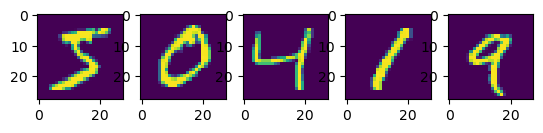

In [3]:
# Load the input data.
# x_train is the training data, and y_train the corresponding true labels
# x_test is the testing data, and y_test the corresponding true labels
# We don't have a separate validation sample in these keras datasets
# Num_classes is the number of true classes
(x_train, y_train), (x_test, y_test), num_classes = load_dataset('mnist')

In [6]:
x_train[0]

array([[[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
      

---

Now we want to define a CNN. The basic building blocks you will need are:


*   Convolutional layers: `keras.layers.Conv2D(num_filters, (k,k), activation='relu')`. Typical values of `k` are 3, 5, or 7
*   Pooling layers: `keras.layers.MaxPooling2D((2,2))` will perform a factor of 2 downsampling in the two dimensions of image
*   Dropout: keras.layers.Dropout(fraction) where fraction is the fraction of weights that are ignored. Typical values can be 0.25 or 0.5
*   Dense layers: `keras.layers.Dense(num_nodes, activation='relu')` where the num_nodes is how many neurons are in the layer. The final layer of the CNN needs have to have `num_nodes = num_classes`
*   Flatten layer: This just converts and n-dimensional tensor into a vector. In this case we use it to present a dense output layer with a vector input


In the following way of writing our network, we need to write things in the form:

`layer_output = keras.layers.LayerNameHere(arguments_go_here)(layer_input)`

For the first CNN we are building, you will hopefully see the following output from the model.summary() command:

```
Model: "model"
_________________________________________________________________
 Layer (type)                 Output Shape              Param #   
=================================================================
 input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)              (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
                                                              
 dropout (Dropout)            (None, 13, 13, 32)        0         
                                                                 
 flatten (Flatten)            (None, 5408)              0         
                                                                 
 dense (Dense)                (None, 10)                54090     
                                                                 
=================================================================
Total params: 54,410
Trainable params: 54,410
Non-trainable params: 0
_________________________________________________________________
```

In [4]:
# Define our simplest model first
input_layer = keras.layers.Input(x_train[0].shape)
x = keras.layers.Conv2D(32, (3,3), activation='relu')(input_layer) # Replace None with a 2D convolution with 32 filters of size (3,3) and relu activation
x = keras.layers.MaxPooling2D((2,2))(x) # Replace None with a MaxPooling2D layer to downsample by a factor of 2 in both dimensions
x = keras.layers.Dropout(0.25)(x) # Replace None with a droput layer with a fraction of 0.25
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(num_classes, activation='softmax')(x) # Replace None with a final dense output layer with num_classes neurons and softmax activation
cnn_model = keras.Model(input_layer, x)
cnn_model.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 13, 13, 32)        0         
                                                                 
 flatten (Flatten)           (None, 5408)              0         
                                                                 
 dense (Dense)               (None, 10)                54090     
                                                           

Let's define some of the hyperparameters:


*   `batch_size` determines how many images we process in parallel. The larger the number the more computationally efficient the network will be, but also the larger the memory footprint.
*   `epochs` is the number of times we iterate over the entire training dataset during the training process
*   `learning_rate` determines the step size taken in the gradient descent algorithm



In [5]:
# The batch size controls the number of images that are processed simultaneously
batch_size = 128
# The number of epochs that we want to train the network for
epochs = 5
# The learning rate (step size in gradient descent)
learning_rate = 0.001

Now we need to get the network ready for training by defining a loss function and the optimiser that we will use to perform the gradient descent. For this task we need to use categorical crossentropy loss (`keras.losses.categorical_crossentropy`) but other losses are required for other tasks.

The code below uses the `Adam` optimiser, but you can investigate using some others to see how they perform. A full list of those available in `keras` can be found here: https://keras.io/api/optimizers/



In [6]:
# Define the loss function - for a multi-class classification task we need to
# use categorical crossentropy loss
loss_function = keras.losses.categorical_crossentropy
# The optimiser performs the gradient descent for us. There are a few different
# algorithms, but Adam is one of the more popular ones
optimiser = keras.optimizers.Adam(learning_rate=learning_rate)
# Now we compile the model with the loss function and optimiser
cnn_model.compile(loss=loss_function, optimizer=optimiser, metrics=['accuracy'])

Now we can run our network on whichever data sample we requested. Initially on `mnist` we'll hopefully see that we can reach a very high accuracy.

To do this, we use the `fit` function of the `cnn_model` object. The full function definition is given here: https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit

However, we only need of the arguments here: `fit(x, y, batch_size, epochs, validation_data, verbose)`


*   `x` is the training data
*   `y` are the training labels
*   `batch_size` is the number of images to process together
*   `epochs` is the number of epochs
*   `validation_data` is the validation sample - we need to use the test sample here. The format here is `(validation_x, validation_y)`.
*   `verbose` allows you to get some visual output. I typically set this to `1`.

In [7]:
# Train the model using the training data with the true target outputs.
# Fill in the required arguments using the clues given above
cnn_model.fit(x = x_train, y = y_train, batch_size = batch_size, epochs = epochs,
              validation_data = (x_test, y_test), verbose = 1)


Epoch 1/5


469/469 [==============================] - 10s 20ms/step - loss: 1.4868 - accuracy: 0.9091 - val_loss: 0.1547 - val_accuracy: 0.9709
Epoch 2/5
469/469 [==============================] - 9s 20ms/step - loss: 0.1608 - accuracy: 0.9628 - val_loss: 0.1056 - val_accuracy: 0.9754
Epoch 3/5
469/469 [==============================] - 9s 19ms/step - loss: 0.1015 - accuracy: 0.9709 - val_loss: 0.0945 - val_accuracy: 0.9749
Epoch 4/5
469/469 [==============================] - 9s 19ms/step - loss: 0.0749 - accuracy: 0.9772 - val_loss: 0.0816 - val_accuracy: 0.9776
Epoch 5/5
469/469 [==============================] - 9s 19ms/step - loss: 0.0665 - accuracy: 0.9798 - val_loss: 0.0839 - val_accuracy: 0.9775


If you used the `verbose = 1` setting, then you should see the final values of the loss and accuracy from the training and test samples.

Since the classification isn't perfect, let's have a look at a few examples of incorrectly classified images. We will run *inference* on the test sample events and look for those that were incorrectly classified. *Inference* corresponds to predicting the class of a given event, and it is also how we run our networks on unseen data. In `keras` we do this with the `predict` member function: https://www.tensorflow.org/api_docs/python/tf/keras/Model#predict

In this example we can just use two of the arguments:
`predict(x, batch_size)`. This function returns a ten-element array containing the score for each class for each event. It therefore has size `(n_images, 10)`

In [8]:
# Make a list of incorrect classifications
incorrect_indices = []
# Let's look at the whole test dataset, but you can reduce this to 1000 or so
# if you want run more quickly
n_images_to_check = x_test.shape[0]
# Use the CNN to predict the classification of the images. It returns an array
# containing the 10 class scores for each image. It is best to write this code
# using the array notation x[:i] that means use all values of x up until
# the index i, such that if you changed the number of images above then it all
# still works efficiently
raw_predictions = cnn_model.predict(x = x_test[:n_images_to_check], batch_size = batch_size)
for i in range(0,n_images_to_check):
  # Remember the raw output from the CNN gives us an array of scores. We want
  # to select the highest one as our prediction. We need to do the same thing
  # for the truth too since we converted our numbers to a categorical
  # representation earlier. We use the np.argmax() function for this
  prediction = np.argmax(raw_predictions[i])
  truth = np.argmax(y_test[i])
  if prediction != truth:
    incorrect_indices.append([i,prediction,truth])
print('Number of images that were incorrectly classified =',len(incorrect_indices))

79/79 [==============================] - 1s 5ms/step
Number of images that were incorrectly classified = 225


Incorrect classification for image 2293 : predicted = 4 with true = 9


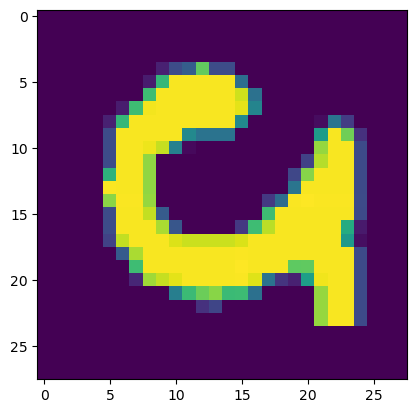

In [12]:
# Now you can modify this part to draw different images from the failures list
# You can change the value of im to look at different failures
im = 66
image_to_plot = x_test[incorrect_indices[im][0]]
fig, ax = plot.subplots(1, 1)
print('Incorrect classification for image',incorrect_indices[im][0],
      ': predicted =',incorrect_indices[im][1],
      'with true =',incorrect_indices[im][2])
ax.imshow(image_to_plot)